<a href="https://colab.research.google.com/github/an-thai-binh/ml_project/blob/main/MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện và truy xuất dataset

In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Input, Flatten, Dense, Dropout, Embedding
from tensorflow.keras.constraints import max_norm
from scikeras.wrappers import KerasClassifier

Kết nối drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ml_lab/project'

Mounted at /content/gdrive
/content/gdrive/MyDrive/ml_lab/project


Đọc dataset

In [ ]:
# Đọc dữ liệu
cirrhosis = pd.read_csv("cirrhosis.csv")
data = cirrhosis.drop(['ID'], axis=1)

# Phân tích dataset



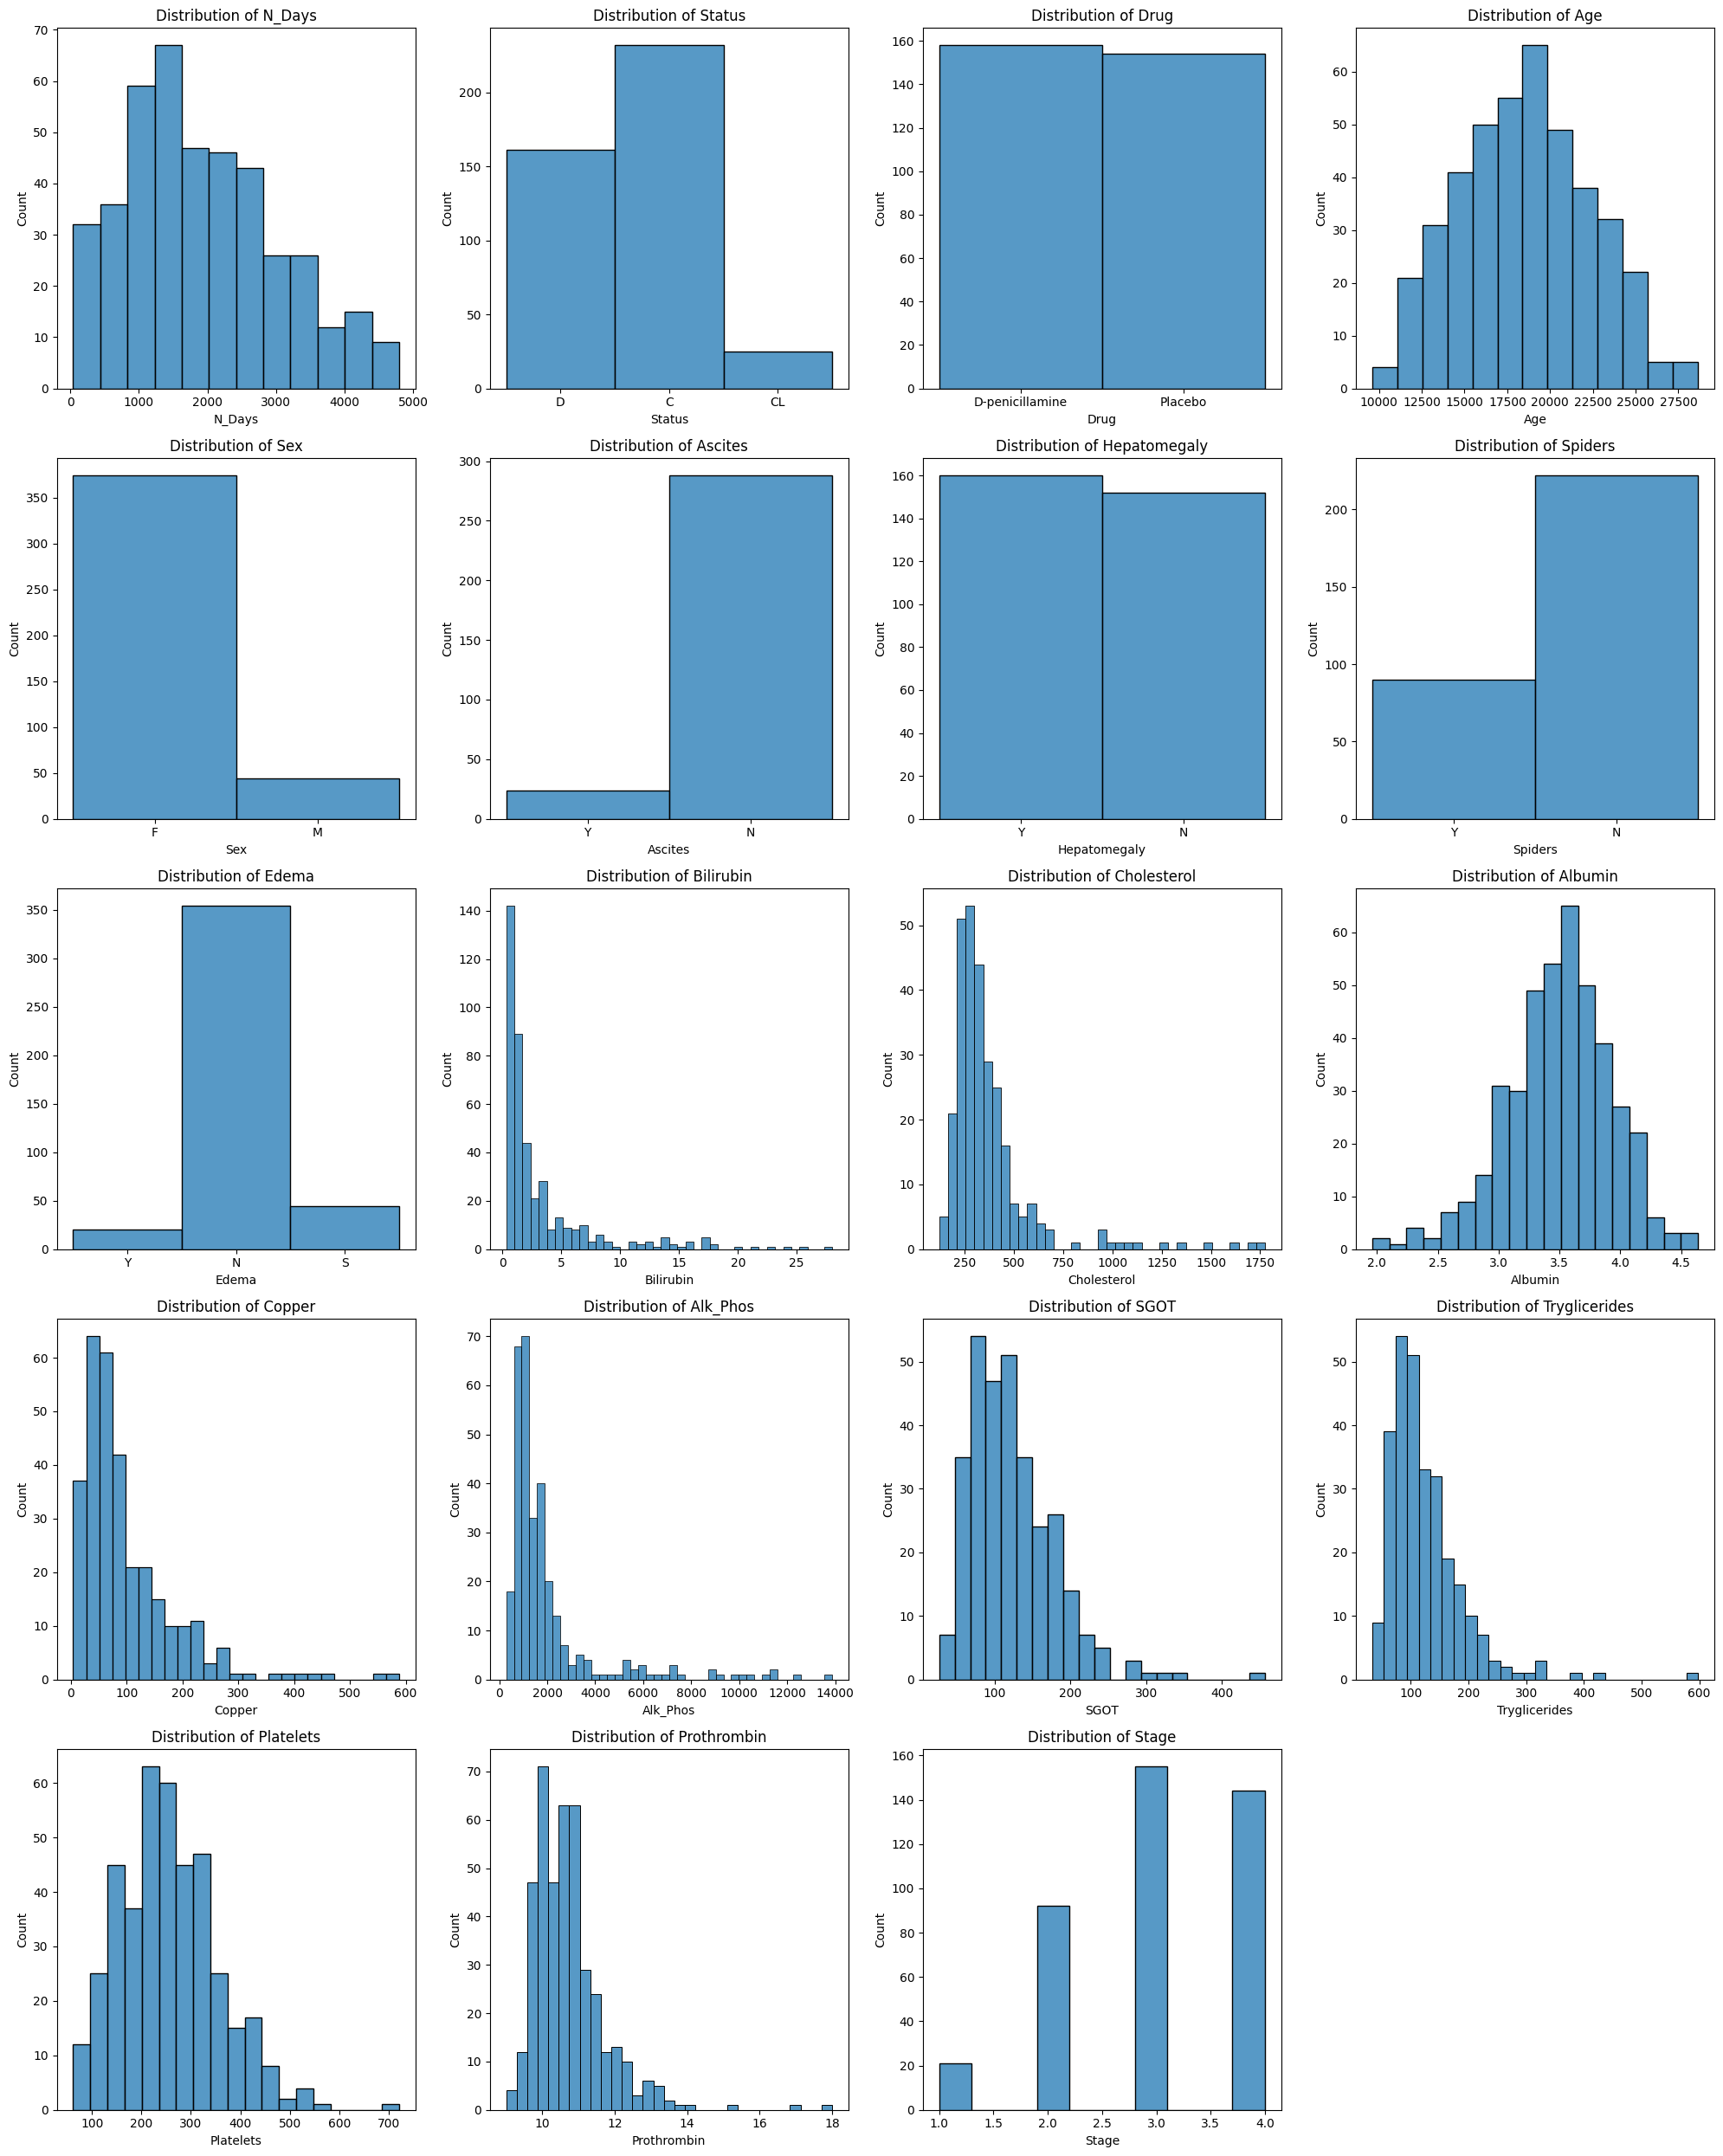

In [ ]:
# Kiểm tra kiểu dữ liệu của các cột
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Tổng số cột
total_plots = len(numerical_cols) + len(categorical_cols)
# Số hàng cần thiết
rows = (total_plots // 4) + (total_plots % 4 > 0)

# Tạo subplot với số hàng và cột phù hợp
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))
axes = axes.flatten()

# Vẽ các biểu đồ cho các cột số
for i, col in enumerate(data):
    sns.histplot(data[col], kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Xoá bỏ các axes không sử dụng
for k in range(len(numerical_cols) + len(categorical_cols), len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

Thống kê số lượng missing value

In [ ]:
data.isnull().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

# Tiền xử lý dữ liệu

1. Xoá 106 trường hợp bệnh nhân không tham gia thử nghiệm

In [ ]:
data.dropna(subset=['Drug'], inplace=True)
data.isnull().sum()

N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

2. Điền các giá trị thiếu còn lại bằng giá trị trung bình

In [ ]:
na_cols = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
for col in na_cols:
  data[col].fillna(data[col].mean(), inplace=True)

3. Sử dụng OneHotEncoder để chuyển dữ liệu categorical sang các cột numeric

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
encoded_columns = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_cols))
data = data.drop(columns=categorical_cols)
data = pd.concat([data, encoded_df], axis=1)
data

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153,22347,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
308,994,21294,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
309,939,22767,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
310,839,13879,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


4. Feature selection

Đánh giá mức độ quan trọng của các thuộc tính sử dụng RandomForestClassifier

In [ ]:
X = data.drop(['Stage'], axis=1)
y = data['Stage']
y = y - 1 # chuyển 1,2,3,4 thành 0,1,2,3
rd = RandomForestClassifier(n_estimators=10)
rd.fit(X, y)
feature_importances = rd.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,N_Days,0.089148
6,Alk_Phos,0.087054
4,Albumin,0.080710
10,Prothrombin,0.080543
1,Age,0.075761
7,SGOT,0.073217
2,Bilirubin,0.068699
8,Tryglicerides,0.067738
3,Cholesterol,0.067462
9,Platelets,0.063018


Chọn những thuộc tính quan trọng

In [ ]:
# Chọn 23 thuộc tính quan trọng nhất
top_features = importance_df.head(23)['Feature']
X = X[top_features]
X

,N_Days,Alk_Phos,Albumin,Prothrombin,Age,SGOT,Bilirubin,Tryglicerides,Cholesterol,Platelets,...,Spiders_Y,Ascites_Y,Status_C,Drug_Placebo,Status_D,Ascites_N,Drug_D-penicillamine,Sex_M,Sex_F,Spiders_N
0,400,1718.0,2.60,12.2,21464,137.95,14.5,172.0,261.0,190.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,4500,7394.8,4.14,10.6,20617,113.52,1.1,88.0,302.0,221.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1012,516.0,3.48,12.0,25594,96.10,1.4,55.0,176.0,151.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,1925,6121.8,2.54,10.3,19994,60.63,1.8,92.0,244.0,183.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
4,1504,671.0,3.53,10.9,13918,113.15,3.4,72.0,279.0,136.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153,797.0,3.58,10.4,22347,91.00,0.4,113.0,246.0,288.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
308,994,1166.0,2.75,10.8,21294,70.00,0.4,82.0,260.0,231.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
309,939,1713.0,3.35,10.2,22767,171.00,1.7,100.0,434.0,234.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
310,839,1050.0,3.16,10.5,13879,117.00,2.0,88.0,247.0,335.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


5. Chia tập dữ liệu (70 train/30 test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

6. Chuẩn hoá dữ liệu sử dụng StandardScaler

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Thực nghiệm

1. Neural network

Xây dựng mô hình sử dụng thư viện Keras

In [ ]:
def custom_model():
  model = keras.models.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dense(4, activation='softmax')
  ])
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model
model = KerasClassifier(model=custom_model)

Sử dụng GridSearchCV tìm ra hyperparameter tốt nhất

In [ ]:
optimizer = ['Adam']
batch_size = [32, 64]
epochs = [30, 50, 70]
param_grid = {"optimizer":optimizer, "batch_size":batch_size, "epochs":epochs}
grid_search_cv = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy'
)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_params_

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2893 - loss: 1.3310  
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3606 - loss: 1.2337 
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4114 - loss: 1.2001 
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5211 - loss: 1.1173 
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5314 - loss: 1.1139 
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6012 - loss: 1.0585 
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5961 - loss: 1.0380 
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5979 - loss: 1.0190 
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5916 - loss: 1.0065 
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5846 - loss: 0.9812 
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5931 - loss: 0.9407 
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6166 - loss: 0.9508 


{'batch_size': 32, 'epochs': 30, 'optimizer': 'Adam'}

Áp dụng các hyperparameter tìm được ở bên trên vào mô hình

In [41]:
# model
model = keras.models.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dense(4, activation='softmax')
])
model.summary()
# compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# fit
history = model.fit(X_train, y_train, epochs=30, batch_size=32)
# evaluate
loss, acc = model.evaluate(X_test, y_test)
print("Loss:" + str(loss))
print("Accuracy:" + str(acc))
# predict
y_pred = model.predict(X_test)
y_pred_nn = np.argmax(y_pred, axis=1)

nn_recall = metrics.recall_score(y_test, y_pred_nn, average='weighted')
nn_f1 = metrics.f1_score(y_test, y_pred_nn, average='weighted')
print(nn_recall, nn_f1)

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_390 (Dense)                    │ (None, 60)                  │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_391 (Dense)                    │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_392 (Dense)                    │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,394 (13.26 KB)

 Trainable params: 3,394 (13.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2795 - loss: 1.5628
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3042 - loss: 1.3860 
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4142 - loss: 1.2586 
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4906 - loss: 1.1812 
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4786 - loss: 1.1616 
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5207 - loss: 1.1316 
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5253 - loss: 1.0583  
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5456 - loss: 1.0090  
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5589 - loss: 1.0172 
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5229 - loss: 1.0016  
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5373 - loss: 1.0113  
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6059 - loss: 0.9284

2. Naive Bayes

Sử dụng GridSearchCV tìm ra hyperparameter tốt nhất

In [35]:
# sử dụng GaussianNB
model = GaussianNB()
param_grid = {
    "var_smoothing": [1e-7, 1e-8, 1e-9]
}
grid_search_cv = GridSearchCV(
  estimator=model,
  param_grid=param_grid,
  scoring='accuracy'
)
grid_search_cv.fit(X_train, y_train)
print("Best hyperparameters:")
print(grid_search_cv.best_params_)

Best hyperparameters:
{'var_smoothing': 1e-07}


Áp dụng các hyperparameter tìm được ở bên trên vào mô hình

In [36]:
gnb = GaussianNB(var_smoothing=1e-07)
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
gnb_recall = metrics.recall_score(y_test, y_pred_gnb, average="weighted")
gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average="weighted")
print(gnb_recall, gnb_f1)

0.5106382978723404 0.5248897431312951


3. Logistic Regression

Sử dụng GridSearchCV tìm ra hyperparameter tốt nhất

In [37]:
model = LogisticRegression()
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ['l2'],
    "solver": ['newton-cg', 'lbfgs'],
    "max_iter": [500, 700, 900]
}
grid_search_cv = GridSearchCV(
  estimator=model,
  param_grid=param_grid,
  scoring='accuracy'
)
grid_search_cv.fit(X_train, y_train)
print("Best hyperparameters:")
print(grid_search_cv.best_params_)

Best hyperparameters:
{'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}


Áp dụng các hyperparameter tìm được ở bên trên vào mô hình

In [39]:
lr = LogisticRegression(C=0.01,max_iter=500, penalty='l2', solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_recall = metrics.recall_score(y_test, y_pred_lr, average="weighted")
lr_f1 = metrics.f1_score(y_test, y_pred_lr, average="weighted")
print(lr_recall, lr_f1)

0.6170212765957447 0.586240309728926


# Kết quả

In [42]:
table = PrettyTable(['algoritm', 'accuracy', 'recall'])
table.add_row(['Neural Network', round(nn_recall, 4), round(nn_f1, 4)])
table.add_row(['GaussianNB', round(gnb_recall, 4), round(gnb_f1, 4)])
table.add_row(['Logistic Regression', round(lr_recall, 4), round(lr_f1, 4)])
print(table)

+---------------------+----------+--------+
|       algoritm      | accuracy | recall |
+---------------------+----------+--------+
|    Neural Network   |  0.6277  | 0.6211 |
|      GaussianNB     |  0.5106  | 0.5249 |
| Logistic Regression |  0.617   | 0.5862 |
+---------------------+----------+--------+
